In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches

In [16]:
data = pd.read_csv('/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Codes/kMC ordenado/data.csv')
data = data.drop(['Unnamed: 10'], axis=1)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data['Fuente(experimento)'] = data.index.astype(str) + '_' + data['Fuente'] + ' (' + data['Experimento'] + ')'
data = data.drop(['Fuente','Experimento'], axis=1)
data.insert(0, 'T0', 0)
data

,T0,T1,T2,T3,T4,T5,T6,T7,T8,Fuente(experimento)
0,0,7.356582,12.689700,16.639759,18.501776,20.487569,23.818749,27.994834,30.050587,0_Adsorcion de As+5 Espana ( 60ppmSb-As)
1,0,20.779935,25.251636,27.748749,29.965348,32.368957,36.389638,43.149442,48.682691,1_Adsorcion de As+5 Espana ( 60ppmAs-As)
2,0,17.067494,22.581181,27.208246,29.441427,31.863017,35.913776,42.724149,48.187964,2_Adsorcion de As+5 Espana ( 90ppmAs-As)
3,0,1.145313,1.696100,2.264219,3.106472,3.699600,4.016499,4.056284,4.106165,3_Adsorcion de Pb Espana (? -FeOOH 0.05 M-Pb)
4,0,6.008902,10.187933,12.134026,13.930267,15.141939,16.922354,20.326410,23.376360,4_Adsorcion de Sb Espana (? -FeOOH 0.05 M-Sb)
5,0,27.241766,41.585839,46.084479,48.311079,49.992389,52.567519,55.551390,57.868871,5_Adsorcion de Sb Espana ( 60ppmSb-Sb)
6,0,34.587323,41.906065,44.300046,46.055632,46.967624,48.723210,51.983584,54.331965,6_Adsorcion de Sb Espana ( 60ppmAs-Sb)
7,0,29.154068,36.910247,42.092633,43.724502,44.948404,50.227982,62.491001,64.050876,7_Adsorcion de Sb Espana ( 60ppmHg-Sb)
8,0,21.817095,29.432051,34.577737,37.286592,39.562941,43.523788,51.331664,56.111996,8_Adsorcion de Sb Espana ( 120ppmAs-Sb)
9,0,12.184766,16.710792,20.125645,22.100067,23.401391,26.923940,33.789545,37.715952,9_Adsorcion de Sb Espana ( 120ppmSb-Sb)


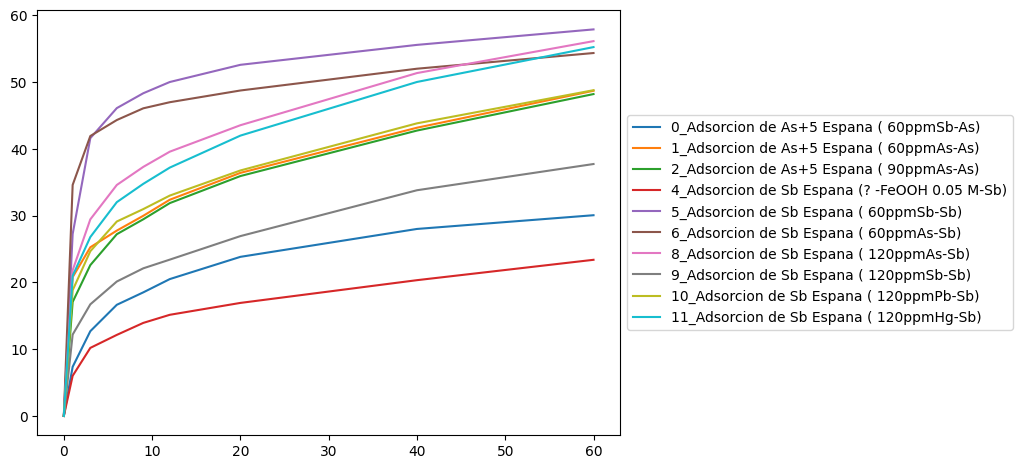

In [5]:
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

for i in range(len(data)):
    if i != 3 and i != 7:
        valores_numericos = pd.to_numeric(data.iloc[i], errors='coerce').dropna()
        etiqueta = data.iloc[i]['Fuente(experimento)']
        plt.plot(time_array, valores_numericos.values, label=etiqueta)

plt.legend()
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        

In [6]:
class LatticeBase(abc.ABC):
    def __init__(self, size):
        self.size = size
        self.lattice = None

    @abc.abstractmethod
    def initialize(self):
        pass

    @abc.abstractmethod
    def get_random_site(self):
        pass

    @abc.abstractmethod
    def get_neighbors(self, site):
        pass

    @abc.abstractmethod
    def get_occupancy(self):
        pass

    @abc.abstractmethod
    def plot(self, title="Estado de la red", figsize=(6,6)):
        pass


In [7]:
class SquareLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site
        return [(ni, nj) for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
                if 0 <= ni < self.size and 0 <= nj < self.size]

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red cuadrada", figsize=(6,6)):
        fig, ax = plt.subplots(figsize=figsize)
        for i in range(self.size):
            for j in range(self.size):
                color = "black" if self.lattice[i, j] == 1 else "white"
                rect = patches.Rectangle((j, self.size - i - 1), 1, 1, edgecolor='gray', facecolor=color)
                ax.add_patch(rect)
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_title(title)
        ax.axis('off')
        plt.show()


In [8]:
import matplotlib.patches as patches
import numpy as np

class HexagonalLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site

        # Definición de vecinos para layout even-r (fila par desplazada)
        if i % 2 == 0:  # Fila par
            deltas = [(-1, 0), (-1, -1),
                    (0, -1),  (0, +1),
                    (+1, 0), (+1, -1)]
        else:  # Fila impar
            deltas = [(-1, +1), (-1, 0),
                    (0, -1),  (0, +1),
                    (+1, +1), (+1, 0)]

        neighbors = [(i + di, j + dj) for di, dj in deltas
                    if 0 <= i + di < self.size and 0 <= j + dj < self.size]

        return neighbors

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red hexagonal", figsize=(6, 6)):
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches

        fig, ax = plt.subplots(figsize=figsize)

        dx = 3 ** 0.5  # horizontal spacing
        dy = 1.5       # vertical spacing
        radius = 0.5

        for i in range(self.size):
            for j in range(self.size):
                x = dx * j + (dx / 2 if i % 2 else 0)
                y = dy * i
                color = "black" if self.lattice[i, j] == 1 else "white"

                hexagon = patches.RegularPolygon(
                    (x, y),
                    numVertices=6,
                    radius=radius,
                    orientation=np.radians(30),
                    edgecolor='gray',
                    facecolor=color,
                    linewidth=0.5
                )
                ax.add_patch(hexagon)

        ax.set_aspect('equal')
        ax.set_xlim(-1, dx * self.size + 1)
        ax.set_ylim(-1, dy * self.size + 1)
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()
        plt.show()




In [9]:
class KineticMonteCarlo:
    def __init__(self, lattice, T, processes, time_array, time_factor=1e-7):
        self.lattice = lattice
        self.T = T
        self.processes = processes
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time_array = time_array
        self.time = time_array[0]

        self.occupancy = {t: None for t in time_array}
        self.events_count = {p: 0 for p in processes}
        self.events_history = {p: [] for p in processes}
        self.times, self.energies = [], []

        self.lattice.initialize()

    # =======================
    #   Transiciones y tasas
    # =======================

    def pick_random_site(self):
        return self.lattice.get_random_site()

    def count_occupied_neighbors(self, site):
        return sum(self.lattice.lattice[n] for n in self.lattice.get_neighbors(site))

    def calculate_transition_rates(self, site):
        n_ij = self.count_occupied_neighbors(site)
        rates = {}

        if "adsorption" in self.processes:
            p = self.processes["adsorption"]
            E_ads = p["e_ads"] + p.get("e_int_abs", 0) * n_ij
            rates["adsorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))

        if "desorption" in self.processes:
            p = self.processes["desorption"]
            E_des = p["e_des"] + p.get("e_int_des", 0) * n_ij
            rates["desorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))

        if "diffusion" in self.processes:
            e_diff = self.processes["diffusion"]["e_diff"]
            rates["diffusion"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-e_diff / (self.k_b * self.T))

        return rates

    def select_event(self, rates):
        total = sum(rates.values())
        r = np.random.rand() * total
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None

    # ===================
    #     Energía
    # ===================

    def calculate_total_energy(self):
        total_energy = 0
        for i in range(self.lattice.size):
            for j in range(self.lattice.size):
                if self.lattice.lattice[i, j] == 1:
                    n_ij = self.count_occupied_neighbors((i, j))
                    e_ads = self.processes["adsorption"]["e_ads"]
                    e_int_abs = self.processes["adsorption"].get("e_int_abs", 0)
                    total_energy += e_ads + e_int_abs * n_ij
        return total_energy

    # ===================
    #     Simulación
    # ===================

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            self._capture_time_snapshot()

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            

            if not rates or sum(rates.values()) == 0:
                break  # Sin eventos posibles

            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            self.time += delta_t

            event = self.select_event(rates)
            self._apply_event(event, site)
            self._update_history(event)

        self._capture_remaining_snapshots()
        return self.occupancy

    def _apply_event(self, event, site):
        if event == "adsorption":
            self.lattice.lattice[site] = 1
        elif event == "desorption" and self.lattice.lattice[site] == 1:
            self.lattice.lattice[site] = 0
        elif event == "diffusion" and self.lattice.lattice[site] == 1:
            neighbors = self.lattice.get_neighbors(site)
            vacant = [n for n in neighbors if self.lattice.lattice[n] == 0]
            if vacant:
                new_site = vacant[np.random.randint(len(vacant))]
                self.lattice.lattice[site], self.lattice.lattice[new_site] = 0, 1

    def _update_history(self, event):
        self.events_count[event] += 1
        for key in self.events_history:
            self.events_history[key].append(self.events_count[key])

    def _capture_time_snapshot(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100
                self.energies.append(self.calculate_total_energy())

    def _capture_remaining_snapshots(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100

    # ===================
    #     Utilidades
    # ===================

    def reset_lattice(self): 
        self.lattice.initialize()
        self.occupancy = {t: None for t in self.time_array}

    def plot_lattice(self, *args, **kwargs):
        self.lattice.plot(*args, **kwargs)


Ocupación final: 30.539444444444445
Energía final: 18684.88288756447


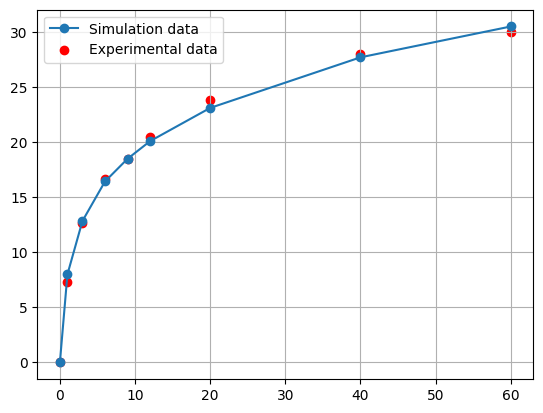

Mean Squared Error (MSE): 0.15356576039614467
{'adsorption': 131387, 'desorption': 182}


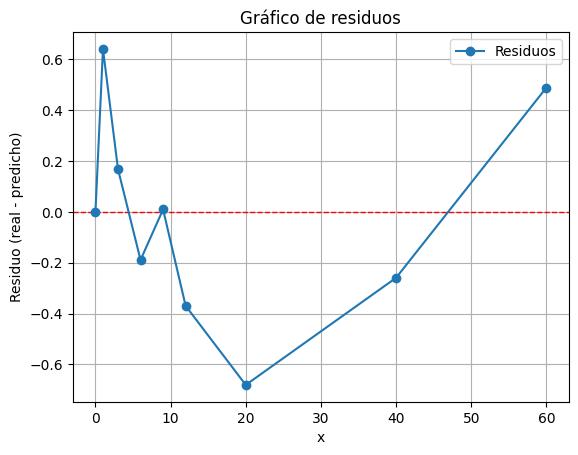

In [10]:
processes = {
    "adsorption": {"e_ads": 0.09023405539892604, "e_int_abs": 0.043612945833991446},
    "desorption": {"e_des": 0.23688561031325336, "e_int_des": 0.7}
}
T = 300.57772973331004
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 600

# Elegí la red: Square o Hexagonal
lattice = HexagonalLattice(size=lattice_size)  # o HexagonalLattice(size=10)

# Crear y correr el modelo
kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
occupancy = kmc.run_simulation()

# Ver resultados básicos
print("Ocupación final:", occupancy[time_array[-1]])
print("Energía final:", kmc.calculate_total_energy())


test = [
    np.float64(0.0),
    np.float64(8.28694444),
    np.float64(13.03083333),
    np.float64(16.45027778),
    np.float64(18.29638889),
    np.float64(20.15527778),
    np.float64(23.04583333),
    np.float64(27.6475),
    np.float64(30.81916667)
]

simulated_data = occupancy.values()
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.scatter(time_array, data.iloc[0, :9].to_numpy(),color = 'red', label='Experimental data')
plt.legend()
plt.grid(True)
plt.show()

mse = np.mean((data.iloc[0, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")
print(kmc.events_count)

# Cálculo de residuos
residuos = np.array(list(simulated_data)) - data.iloc[0, :9].to_numpy()

# Gráfico de residuos

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.plot(time_array, residuos, marker='o', linestyle='-', label='Residuos')
plt.title('Gráfico de residuos')
plt.xlabel('x')
plt.ylabel('Residuo (real - predicho)')
plt.legend()
plt.grid(True)
plt.show()

Simulación 1: Ocupación final = 30.656111111111112
Simulación 2: Ocupación final = 30.543333333333333
Simulación 3: Ocupación final = 29.73777777777778
Simulación 4: Ocupación final = 29.9825
Simulación 5: Ocupación final = 30.470277777777778
Simulación 6: Ocupación final = 30.12666666666667
Simulación 7: Ocupación final = 30.011666666666663
Simulación 8: Ocupación final = 30.568055555555556
Simulación 9: Ocupación final = 30.393055555555552
Simulación 10: Ocupación final = 30.44472222222222
Simulación 11: Ocupación final = 30.352777777777778
Simulación 12: Ocupación final = 30.478055555555557
Simulación 13: Ocupación final = 30.291111111111114
Simulación 14: Ocupación final = 30.50611111111111
Simulación 15: Ocupación final = 30.619166666666665
Simulación 16: Ocupación final = 29.95611111111111
Simulación 17: Ocupación final = 30.112499999999997
Simulación 18: Ocupación final = 30.24527777777778
Simulación 19: Ocupación final = 30.41305555555556
Simulación 20: Ocupación final = 30.196

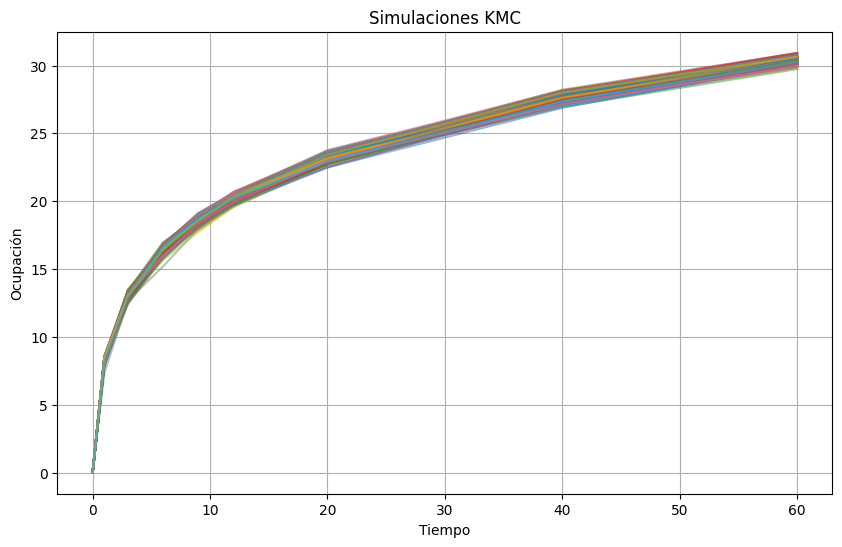

In [12]:
processes = {
    "adsorption": {"e_ads": 0.09023405539892604, "e_int_abs": 0.043612945833991446},
    "desorption": {"e_des": 0.23688561031325336, "e_int_des": 0.7}
}
T = 300.57772973331004
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 600
n_simulations = 200  # o el número que desees

all_curves = []

for i in range(n_simulations):
    lattice = HexagonalLattice(size=lattice_size)
    kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
    occupancy = kmc.run_simulation()
    
    curve = np.array([occupancy[t] for t in time_array])
    all_curves.append(curve)

    print(f"Simulación {i+1}: Ocupación final = {curve[-1]}")

# Convertir a array para análisis posterior
all_curves = np.array(all_curves)  # shape: (n_simulations, len(time_array))

# Opcional: Guardar en CSV o visualizar en conjunto
# Ejemplo de guardado:
np.savetxt("kmc_simulations.csv", all_curves, delimiter=",", header=",".join(map(str, time_array)), comments='')

# Plot opcional de todas las curvas
plt.figure(figsize=(10, 6))
for curve in all_curves:
    plt.plot(time_array, curve, alpha=0.5)
plt.title('Simulaciones KMC')
plt.xlabel('Tiempo')
plt.ylabel('Ocupación')
plt.grid(True)
plt.show()

Tiempo 0: p-value = 1.0000 → Normal


/Users/gtorres/Desktop/proyecto/.venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/gtorres/Desktop/proyecto/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1988: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


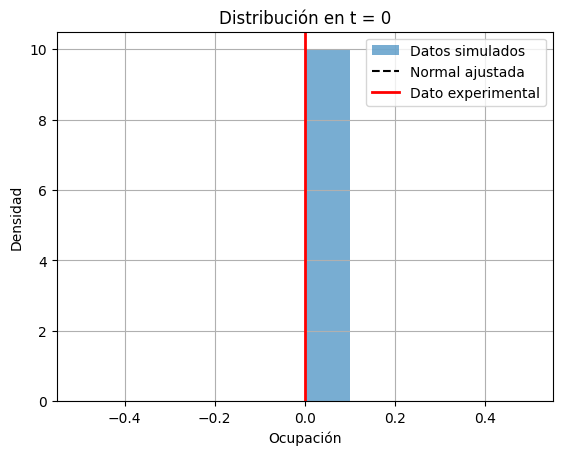

Tiempo 1: p-value = 0.0000 → No normal


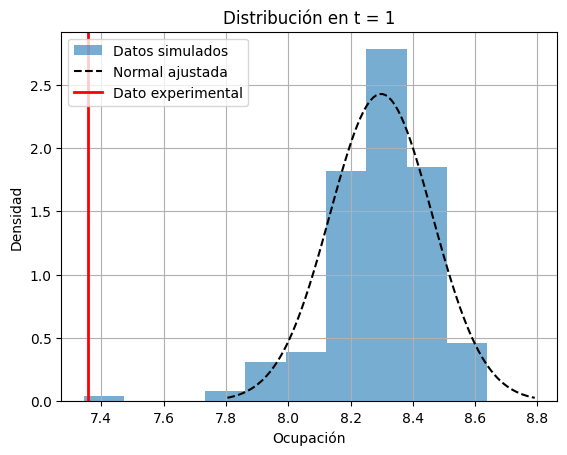

Tiempo 3: p-value = 0.0982 → Normal


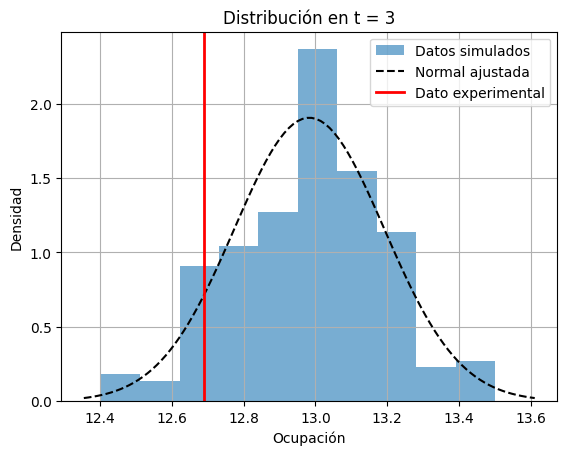

Tiempo 6: p-value = 0.0000 → No normal


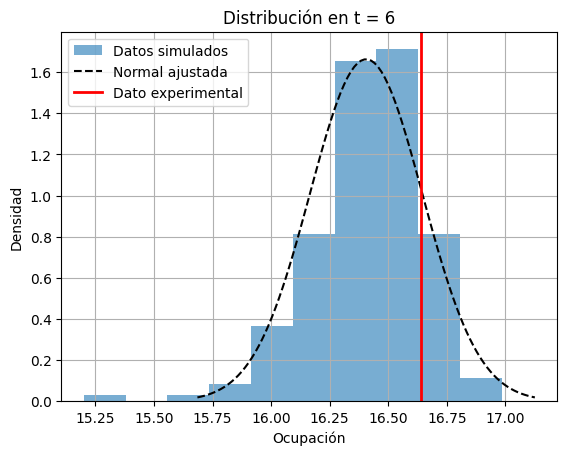

Tiempo 9: p-value = 0.0170 → No normal


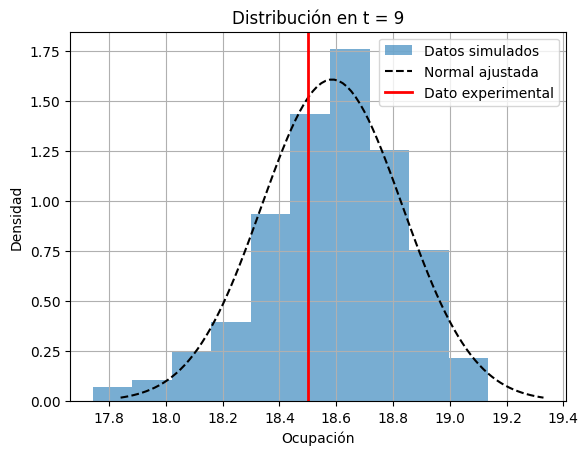

Tiempo 12: p-value = 0.0113 → No normal


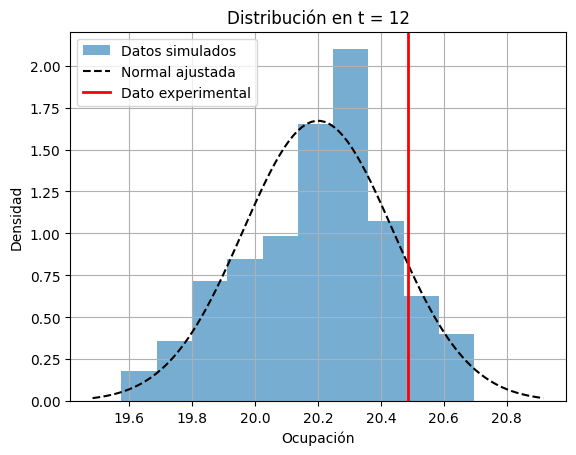

Tiempo 20: p-value = 0.2571 → Normal


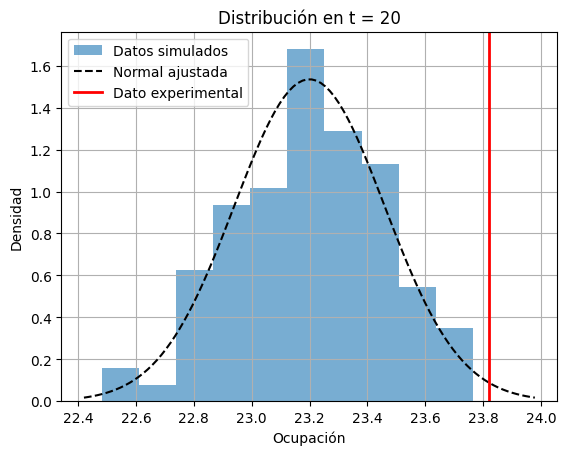

Tiempo 40: p-value = 0.4320 → Normal


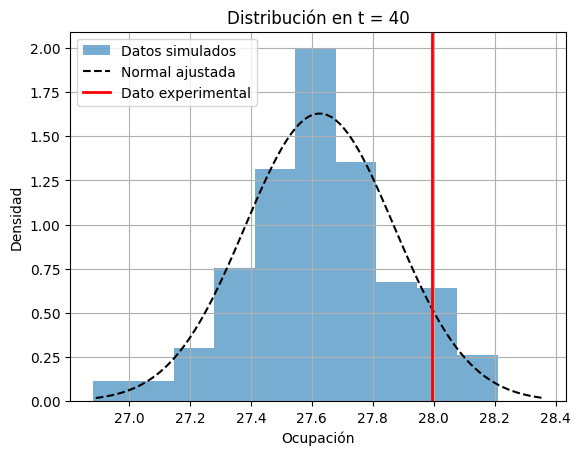

Tiempo 60: p-value = 0.8055 → Normal


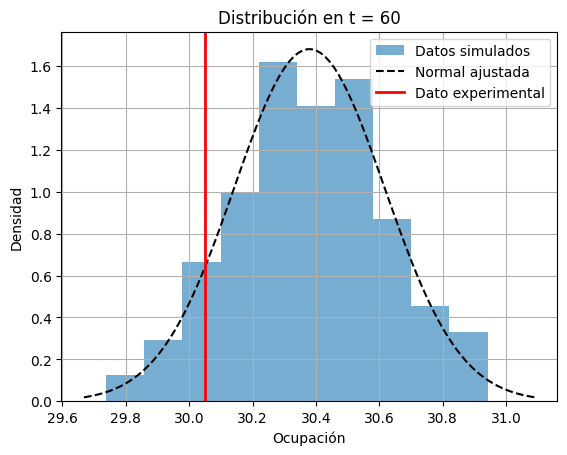

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, norm

# Suponiendo que ya tienes all_curves y data definido
experimental = data.iloc[0, :9].to_numpy()

for i, t in enumerate(time_array):
    simulated = all_curves[:, i]
    exp_value = experimental[i]

    # Test de Shapiro-Wilk
    stat, p = shapiro(simulated)
    print(f"Tiempo {t}: p-value = {p:.4f} → {'Normal' if p > 0.05 else 'No normal'}")

    # Parámetros de la normal
    mu, sigma = np.mean(simulated), np.std(simulated)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = norm.pdf(x, mu, sigma)

    # Graficar
    plt.figure()
    plt.hist(simulated, bins=10, density=True, alpha=0.6, label='Datos simulados')
    plt.plot(x, y, 'k--', label='Normal ajustada')
    plt.axvline(exp_value, color='red', linestyle='-', linewidth=2, label='Dato experimental')
    
    plt.title(f'Distribución en t = {t}')
    plt.xlabel('Ocupación')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.show()


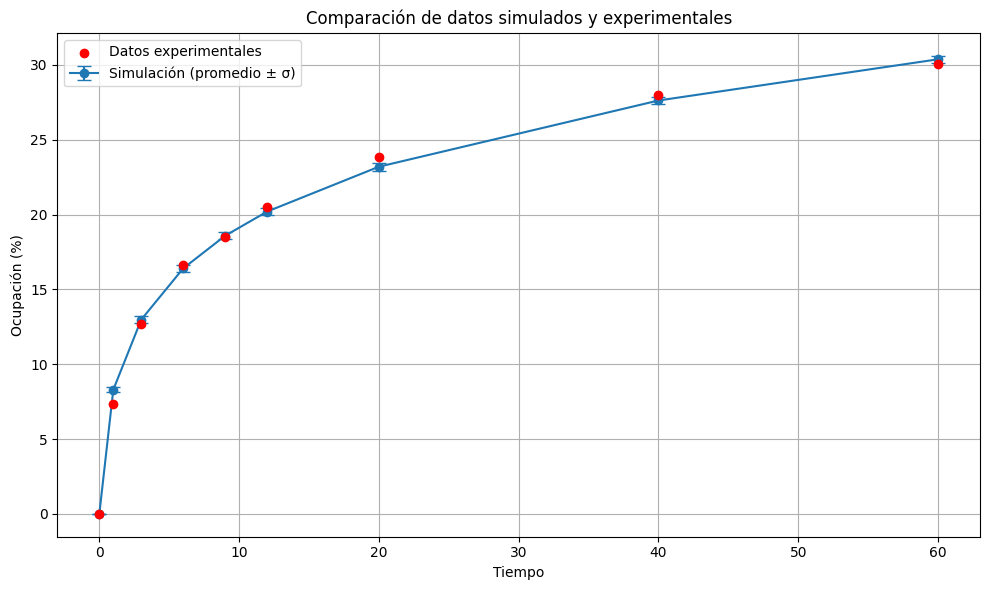

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Asumiendo que tenés:
# - all_curves: (n_simulaciones, len(time_array))
# - time_array: np.array([...])
# - data: DataFrame con datos experimentales en data.iloc[0, :]

# Calcular medias y desviaciones estándar
mean_values = np.mean(all_curves, axis=0)
std_values = np.std(all_curves, axis=0)
experimental_values = data.iloc[0, :len(time_array)].to_numpy()

# Graficar
plt.figure(figsize=(10, 6))

# Curva simulada con barras de error
plt.errorbar(
    time_array,
    mean_values,
    yerr=std_values,
    fmt='o-', capsize=5, label='Simulación (promedio ± σ)'
)

# Puntos experimentales
plt.scatter(
    time_array,
    experimental_values,
    color='red',
    label='Datos experimentales',
    zorder=5
)

# Opciones de gráfico
plt.title("Comparación de datos simulados y experimentales")
plt.xlabel("Tiempo")
plt.ylabel("Ocupación (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/0j/wjdr50f52rs1fylv6znxjsbm0000gn/T/ipykernel_76156/1234446676.py:39: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


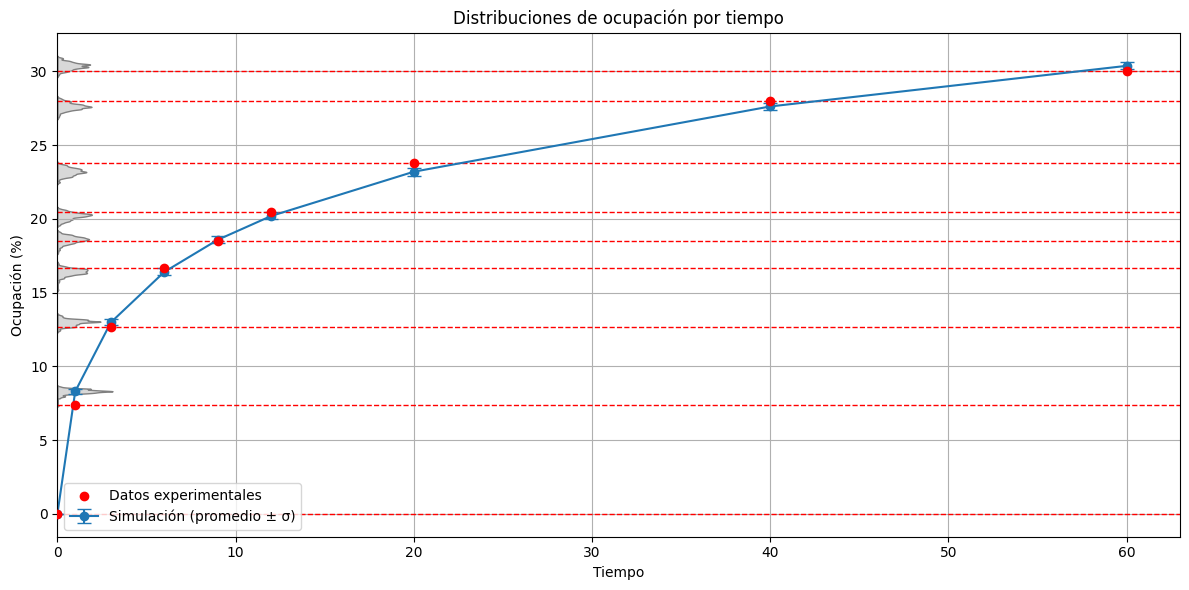

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que ya tienes:
# - all_curves: array de forma (n_simulaciones, len(time_array))
# - time_array: array de tiempos
# - data: DataFrame con datos experimentales

# Calcular medias y desviaciones estándar
mean_values = np.mean(all_curves, axis=0)
std_values = np.std(all_curves, axis=0)
experimental_values = data.iloc[0, :len(time_array)].to_numpy()

plt.figure(figsize=(12, 6))

# Graficar la curva de promedio con barras de error
plt.errorbar(
    time_array,
    mean_values,
    yerr=std_values,
    fmt='o-', capsize=5,
    label='Simulación (promedio ± σ)'
)

# Graficar los puntos experimentales
plt.scatter(
    time_array,
    experimental_values,
    color='red',
    label='Datos experimentales',
    zorder=5
)

# Graficar las curvas de densidad para cada punto de tiempo
for i, t in enumerate(time_array):
    sample = all_curves[:, i]
    sns.kdeplot(
        y=sample,
        bw_adjust=0.5,
        fill=True,
        alpha=0.3,
        color='gray',
        linewidth=1
    )
    # Añadir una línea vertical al dato experimental
    plt.axhline(y=experimental_values[i], color='red', linestyle='--', linewidth=1)

# Configurar el gráfico
plt.title("Distribuciones de ocupación por tiempo")
plt.xlabel("Tiempo")
plt.ylabel("Ocupación (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error

# Asegurate de tener:
# - mean_values: promedio de simulaciones por tiempo
# - experimental_values: datos reales

mse = mean_squared_error(experimental_values, mean_values)
print(f"Mean Squared Error (MSE): {mse:.4f}")


Mean Squared Error (MSE): 0.1938


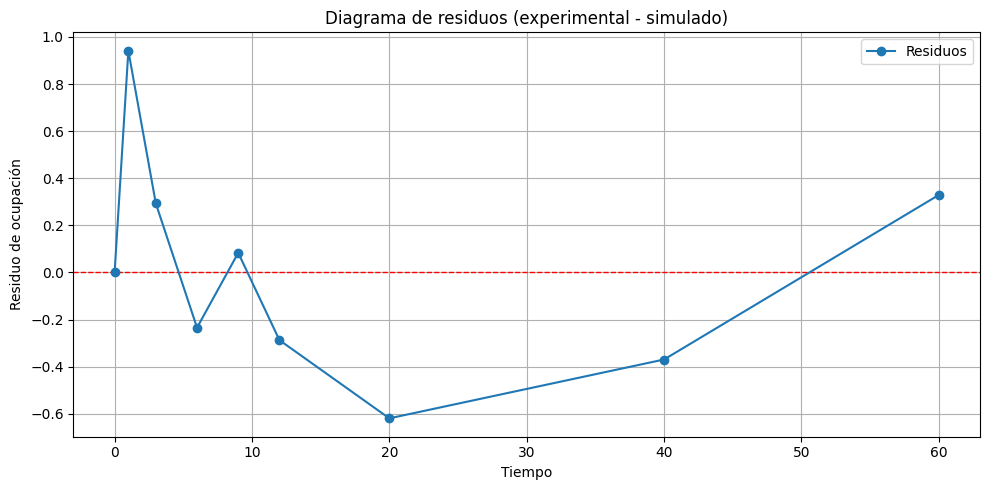

In [25]:
import matplotlib.pyplot as plt

# Cálculo de residuos: real - predicho
residuos =  mean_values - experimental_values

# Gráfico de residuos
plt.figure(figsize=(10, 5))
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.plot(time_array, residuos, marker='o', linestyle='-', label='Residuos')

plt.title('Diagrama de residuos (experimental - simulado)')
plt.xlabel('Tiempo')
plt.ylabel('Residuo de ocupación')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
